# Определение перспективного тарифа для телеком-компании

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Выгрузка-данных.-Подготовка-к-анализу." data-toc-modified-id="Выгрузка-данных.-Подготовка-к-анализу.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выгрузка данных. Подготовка к анализу.</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Проверка-гипотез" data-toc-modified-id="Проверка-гипотез-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка гипотез</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

### Описание проекта

**Заказчик исследования** — компания «Мегалайн», федеральный оператор сотовой связи.

**Задача** — проанализировать поведение клиентов и сделать вывод — какой из двух представленных тарифов лучше.

**Исходные данные** — данные 500 пользователей «Мегалайна» за 2018 год.

Для каждого пользователя требуется посчитать:

- Количество сделанных звонков и израсходованных минут разговора по месяцам;

- Количество отправленных сообщений по месяцам;

- Объем израсходованного интернет-трафика по месяцам;

- Помесячную выручку с каждого пользователя.

Необходимо проверить две гипотезы:

- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются; 

- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 

### Выгрузка данных. Подготовка к анализу.

In [1]:
import pandas as pd   # импорт библиотек
import numpy as np
import seaborn as sns
import scipy.stats as st
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings   # отключение варнингов
warnings.filterwarnings("ignore")

In [2]:
calls, internet, messages, tariffs, users = (
    pd.read_csv('/datasets/calls.csv'), # звонки
    pd.read_csv('/datasets/internet.csv'), # интернет
    pd.read_csv('/datasets/messages.csv'), # сообщения
    pd.read_csv('/datasets/tariffs.csv'), # тарифы
    pd.read_csv('/datasets/users.csv') # пользователи
)

display(calls.head(), internet.head(), messages.head(), tariffs.head(), users.head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Подготовим данные к анализу. Для этого необходимо проверить данные на наличие пропусков, дубликатов и артефактов, убедиться, что типы данных во всех колонках соответствуют сохранённым в них значениям. Ознакомимся с более подробной информацией о каждом из датафреймов. 

In [3]:
calls.info() # получение информации о датафрейме calls
print()
print(calls.isna().sum()) # количество пропусков
print()
print(calls.duplicated().sum()) # количество дубликатов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

id           0
call_date    0
duration     0
user_id      0
dtype: int64

0


В датафрейме `calls` не обнаружено пропусков и дубликатов. Однако, есть проблема с типами данных. В частности, столбец 'call_date' (дата звонка) имеет тип 'object' вместо ожидаемого 'datetime64'. Данные в столбце 'duration' (длительность звонка в минутах) необходимо округлить до целых значений в большую сторону, поскольку «Мегалайн» всегда округляет секунды до минут и каждый звонок округляется отдельно, а следовательно в типе 'float64' нет необходимости. В столбце 'id' хранятся уникальные номера звонков типа 'object', в отличие от 'user_id' ('int64'). Однако, учитывая специфику формы записи номеров звонков ('идентификатор пользователя _ номер звонка'), данный столбец можно оставить без изменений.   

In [4]:
calls['call_date']= pd.to_datetime(
    calls['call_date'], format='%Y-%m-%d') # перевод данных в формат даты
calls['duration'] = np.ceil(calls['duration']).astype('int') # округление и замена типа данных на целочисленный

Далее, датафрейм `internet`.

In [5]:
internet.info() # получение информации о датафрейме internet
print()
print(internet.isna().sum()) # количество пропусков
print()
print(internet.duplicated().sum()) # количество дубликатов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

0


Пропусков и дубликатов не обнаружено. Есть проблема с типом данных в столбце 'session_date': следует привести его к 'datetime64'. Данные в столбце 'mb_used' (объём потраченного за сессию интернет-трафика), в отличие от продолжительности звонков, округлять и приводить к типу 'int64' пока нет необходимости, поскольку для веб-трафика отдельные сессии не считаются и вместо этого общая сумма за месяц округляется до гигабайтов в бо́льшую сторону. Примечательно, что в данной таблице появился столбец 'Unnamed: 0' типа 'int64', который отсутствовал в описании данных. Следует также изучить и его.

In [6]:
internet['session_date']= pd.to_datetime(
    internet['session_date'], format='%Y-%m-%d') # перевод данных в формат даты

print(internet['Unnamed: 0'].head()) # исследуем столбец 'Unnamed: 0'
print(internet['Unnamed: 0'].tail())
print(internet['Unnamed: 0'].max())
print(internet['Unnamed: 0'].min())
print(internet['Unnamed: 0'].duplicated().value_counts())

0    0
1    1
2    2
3    3
4    4
Name: Unnamed: 0, dtype: int64
149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, dtype: int64
149395
0
False    149396
Name: Unnamed: 0, dtype: int64


Судя по всему, данный столбец дублирует индексы строк. На это указывает отсутствие пропусков и повторений, а также то, что значения идут по порядку, при минимальном значении 0 и максимальном 149395, что соответствует индексам первой и последней строки. Таким образом, от данного столбца можно избавиться без потери каких-либо данных.

In [7]:
internet = internet.drop(['Unnamed: 0'], axis=1) # удаление столбца

Далее, датафрейм `messages`.

In [8]:
messages.info() # получение информации о датафрейме messages
print()
print(messages.isna().sum()) # количество пропусков
print()
print(messages.duplicated().sum()) # количество дубликатов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

id              0
message_date    0
user_id         0
dtype: int64

0


Пропусков и дубликатов не обнаружено. Есть проблема с типом данных в столбце 'message_date': следует привести его к 'datetime64'.

In [9]:
messages['message_date']= pd.to_datetime(
    messages['message_date'], format='%Y-%m-%d') # перевод данных в формат даты

Далее, датафрейм `tariffs`.

In [10]:
tariffs.info() # получение информации о датафрейме tariffs
print()
print(tariffs.isna().sum()) # количество пропусков
print()
print(tariffs.duplicated().sum()) # количество дубликатов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

0


В данной таблице проблем не обнаружено. Перейдем к последнему датафрейму `users`.

In [11]:
users.info() # получение информации о датафрейме users
print()
print(users.isna().sum()) # количество пропусков
print()
print(users.duplicated().sum()) # количество дубликатов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

0


В датафрейме `users` присутствуют 462 пропуска в столбце 'churn_date'. Однако, согласно описанию проекта, пропуски в столбце churn_date означают, что тариф ещё действовал на момент выгрузки данных, а потому их не следует устранять. Следует привести столбцы 'churn_date' и 'reg_date' к типу 'datetime64'.    

In [12]:
users['reg_date']= pd.to_datetime(
    users['reg_date'], format='%Y-%m-%d') # перевод данных в формат даты
users['churn_date']= pd.to_datetime(
    users['churn_date'], format='%Y-%m-%d')
users = users.rename(columns={'tariff' : 'tariff_name'})

В ходе данного этапа были выявлены и устранены следующие проблемы: столбы 'reg_date', 'churn_date', 'call_date', 'message_date', 'session_date' приведены к типу 'datetime64'; данные в столбце 'duration' (длительность звонка в минутах) были округлены до целых значений в большую сторону; в таблице `internet` был удален столбец 'Unnamed: 0', дублирующий индексы строк.

Таким образом, данные приведены в пригодный для анализа вид. 

### Анализ данных

Перейдем к анализу данных. Согласно поставленной цели, необходимо определить, какой из двух тарифов приносит больше денег. Для этого требуется проанализировать поведение клиентов. 

Расчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

Для начала, узнаем сколько пользователей у каждого тарифа.

In [13]:
users['tariff_name'].value_counts() # считаем количество пользователей обоих тарифов

smart    351
ultra    149
Name: tariff_name, dtype: int64

Пользователей тарифа smart оказалось больше на 202 человека. Учитывая, что тариф ultra является более дорогим, результат вполне ожидаемый.

Далее, расчитаем количество звонков и минут для каждого пользователя по месяцам.

In [14]:
calls['month'] = calls['call_date'].dt.month  # создаем столбец с месяцами звонков
calls['month'] = calls['month'].dropna()      # устраняем 8 пропусков
calls['month'] = calls['month'].astype('int') # переводим номера месяцев в целочисленный вид

udpmc = calls.groupby(['user_id', 'month']).agg(calls_total = ('id', 'count'),        # user`s data per month calls (udpmc): 
                  minutes_total = ('duration', 'sum'))                                # данные о звонках пользователей по месяцам 
                                                                                
display(udpmc.sort_values(by=['user_id', 'month'])) 

calls_total  minutes_total
user_id month                            
1000    5               22            159
        6               43            172
        7               47            340
        8               52            408
        9               58            466
...                    ...            ...
1498    10              41            247
1499    9                9             70
        10              68            449
        11              74            612
        12              69            492

[3174 rows x 2 columns]

In [15]:
messages['month'] = messages['message_date'].dt.month  # создаем столбец с месяцами сообщений
messages['month'] = messages['month'].dropna()         # устраняем пропуски
messages['month'] = messages['month'].astype('int')    # переводим номера месяцев в целочисленный вид

udpmm = messages.groupby(['user_id', 'month']).agg(messages_total = ('id', 'count')) # user`s data per month messages (udpmm):
                                                                                     # данные о сообщениях по месяцам

display(udpmm.sort_values(by=['user_id', 'month'])) 

messages_total
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

In [16]:
internet['month'] = internet['session_date'].dt.month  # создаем столбец с месяцами сессий
internet['month'] = internet['month'].dropna('')         # устраняем пропуски
internet['month'] = internet['month'].astype('int')    # переводим номера месяцев в целочисленный вид

udpmi = internet.groupby(['user_id', 'month']).agg(mb_used_total = ('mb_used', 'sum')) # user`s data per month internet (udpmi): 
                                                                                       # данные о трафике по месяцам

udpmi['mb_used_total'] = np.ceil(udpmi['mb_used_total']).astype('int') # округляем Мб до целого в большую сторону

display(udpmi.sort_values(by=['user_id', 'month']))

mb_used_total
user_id month               
1000    5               2254
        6              23234
        7              14004
        8              14056
        9              14569
...                      ...
1498    10             20580
1499    9               1846
        10             17789
        11             17964
        12             13056

[3203 rows x 1 columns]

In [17]:
udpm = udpmc.join(udpmm, on=['user_id', 'month'], how='outer') # создаем объединенный датафрейм user`s data per month (udpm)
udpm = udpm.join(udpmi, on=['user_id', 'month'], how='outer')
users = users.merge(tariffs, on='tariff_name', how='outer')
udpm = udpm.reset_index(level=['user_id', 'month'])
udpm = udpm.merge(users, on='user_id', how='outer')

udpm = udpm[['user_id', 
             'month',
             'first_name', 
             'last_name', 
             'age', 
             'reg_date', 
             'churn_date', 
             'city', 
             'tariff_name', 
             'calls_total', 
             'minutes_total', 
             'messages_total', 
             'mb_used_total', 
             'rub_monthly_fee', 
             'minutes_included', 
             'messages_included', 
             'mb_per_month_included', 
             'rub_per_minute', 
             'rub_per_message', 
             'rub_per_gb']]

udpm = udpm.sort_values(by=['user_id', 'month']) # настраиваем сортировку

udpm['calls_total'] = udpm['calls_total'].fillna(0) # заполняем пропуски нулями и приводим к типу int
udpm['calls_total'] = udpm['calls_total'].astype('int')

udpm['minutes_total'] = udpm['minutes_total'].fillna(0)
udpm['minutes_total'] = udpm['minutes_total'].astype('int')

udpm['messages_total'] = udpm['messages_total'].fillna(0)
udpm['messages_total'] = udpm['messages_total'].astype('int')

udpm['mb_used_total'] = udpm['mb_used_total'].fillna(0)
udpm['mb_used_total'] = udpm['mb_used_total'].astype('int')

udpm['month'] = udpm['month'].fillna(0)
udpm['month'] = udpm['month'].astype('int')

udpm.info() # повторно проверяем типы данных и выводим итоговый датафрейм на экран
display(udpm.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3175
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3216 non-null   int64         
 2   first_name             3216 non-null   object        
 3   last_name              3216 non-null   object        
 4   age                    3216 non-null   int64         
 5   reg_date               3216 non-null   datetime64[ns]
 6   churn_date             189 non-null    datetime64[ns]
 7   city                   3216 non-null   object        
 8   tariff_name            3216 non-null   object        
 9   calls_total            3216 non-null   int64         
 10  minutes_total          3216 non-null   int64         
 11  messages_total         3216 non-null   int64         
 12  mb_used_total          3216 non-null   int64         
 13  rub

,user_id,month,first_name,last_name,age,reg_date,churn_date,city,tariff_name,calls_total,minutes_total,messages_total,mb_used_total,rub_monthly_fee,minutes_included,messages_included,mb_per_month_included,rub_per_minute,rub_per_message,rub_per_gb
0,1000,5,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,22,159,22,2254,1950,3000,1000,30720,1,1,150
1,1000,6,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,43,172,60,23234,1950,3000,1000,30720,1,1,150
2,1000,7,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,47,340,75,14004,1950,3000,1000,30720,1,1,150
3,1000,8,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,52,408,81,14056,1950,3000,1000,30720,1,1,150
4,1000,9,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,58,466,57,14569,1950,3000,1000,30720,1,1,150


In [18]:
def det_revenue(row): # функция для расчета выручки с каждого пользователя по месяцам в зависимости от тарифа
    messages = row['messages_total']
    mb_used = row['mb_used_total']
    tariff = row['tariff_name']
    duration = row['minutes_total']
    calls = row['calls_total']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_gb = np.ceil((mb_used - tariffs.loc[0, 'mb_per_month_included']) / 1024)
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_gb < 0: extra_gb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[0, 'rub_per_gb']) * extra_gb + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_gb = np.ceil((mb_used - tariffs.loc[1, 'mb_per_month_included']) / 1024)
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_gb < 0: extra_gb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[1, 'rub_per_gb']) * extra_gb + 
                   tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

udpm['revenue'] = udpm.apply(det_revenue, axis=1) # применяем функцию для создания столбца 'revenue', т.е. выручки
udpm.head(10)

,user_id,month,first_name,last_name,age,reg_date,churn_date,city,tariff_name,calls_total,...,messages_total,mb_used_total,rub_monthly_fee,minutes_included,messages_included,mb_per_month_included,rub_per_minute,rub_per_message,rub_per_gb,revenue
0,1000,5,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,22,...,22,2254,1950,3000,1000,30720,1,1,150,1950.0
1,1000,6,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,43,...,60,23234,1950,3000,1000,30720,1,1,150,1950.0
2,1000,7,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,47,...,75,14004,1950,3000,1000,30720,1,1,150,1950.0
3,1000,8,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,52,...,81,14056,1950,3000,1000,30720,1,1,150,1950.0
4,1000,9,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,58,...,57,14569,1950,3000,1000,30720,1,1,150,1950.0
5,1000,10,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,57,...,73,14703,1950,3000,1000,30720,1,1,150,1950.0
6,1000,11,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,43,...,58,14757,1950,3000,1000,30720,1,1,150,1950.0
7,1000,12,Рафаил,Верещагин,52,2018-05-25,NaT,Краснодар,ultra,46,...,70,9818,1950,3000,1000,30720,1,1,150,1950.0
8,1001,11,Иван,Ежов,41,2018-11-01,NaT,Москва,smart,59,...,0,18430,550,500,50,15360,3,3,200,1150.0
9,1001,12,Иван,Ежов,41,2018-11-01,NaT,Москва,smart,63,...,0,14037,550,500,50,15360,3,3,200,550.0


Теперь, когда создан объединенный датафрейм и расчитаны основные показатели, необходимо определить средние потребности каждого пользователя в месяц по количеству минут, сообщений и мегабайт. Сделать это можно, построив сводную таблицу и применив агрегирующую функцию mean. 

In [19]:
means = udpm.pivot_table(index=['user_id', 'tariff_name'],
                         values=['minutes_total', 'messages_total', 'mb_used_total', 'revenue'], 
                         aggfunc='mean') # расчет средних для каждого пользователя

means = means.reset_index(level='tariff_name') # преобразуем индекс в столбец

means = means.rename(columns={'mb_used_total' : 'mb_used_mean', 
                              'messages_total' : 'messages_mean', 
                              'minutes_total' : 'minutes_mean', 
                              'revenue' : 'revenue_mean'}) # переименовываем столбцы, т.к теперь они показывают средние значения

means = means[['minutes_mean', 'messages_mean', 'mb_used_mean', 'revenue_mean', 'tariff_name']]
means.round(1).head() # выводим таблицу со средними значениями

,minutes_mean,messages_mean,mb_used_mean,revenue_mean,tariff_name
user_id,,,,,
1000,320.8,62.0,13424.4,1950.0,ultra
1001,422.0,0.0,16233.5,850.0,smart
1002,216.7,10.0,16577.3,1035.7,smart
1003,764.4,76.0,11456.6,1950.0,ultra
1004,123.4,149.0,18630.6,1950.0,ultra


Далее, найдем среднее, медиану, дисперсию и стандартное отклонение для пользователей обоих тарифов:

In [20]:
stats = udpm.pivot_table(index=['tariff_name'], values=['minutes_total', 'mb_used_total', 'messages_total'], 
                    aggfunc={'minutes_total': [np.mean, np.median, np.var, np.std], 
                             'mb_used_total': [np.mean, np.median, np.var, np.std], 
                             'messages_total': [np.mean, np.median, np.var, np.std]})
stats.round(1)

mb_used_total                                messages_total  \
                     mean   median      std          var           mean   
tariff_name                                                               
smart             16201.6  16506.0   5879.2   34564916.9           33.4   
ultra             19449.6  19305.0  10101.1  102032693.0           49.3   

                                 minutes_total                          
            median   std     var          mean median    std       var  
tariff_name                                                             
smart         28.0  28.2   797.0         417.7  421.5  190.5   36281.4  
ultra         38.0  47.8  2285.4         526.1  518.0  317.9  101052.5

Согласно таблице, в среднем, пользователи тарифа ultra расходуют больше минут, сообщений и мегабайт, чем пользователи тарифа smart. Примечательно, что пользователи тарифа ultra в среднем расходуют Мб трафика существенно меньше лимита (19449 из 30720 Мб), в то время как пользователям smart лимита часто не хватает (в среднем, расход 16201 Мб при лимите 15360). Также стоит отметить, что дисперсия всех трех величин у тарифа ultra больше, чем у тарифа smart.

Построим диаграммы размаха и гистограммы для оценки характеристик распределения.

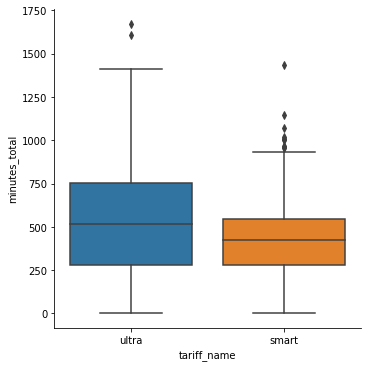

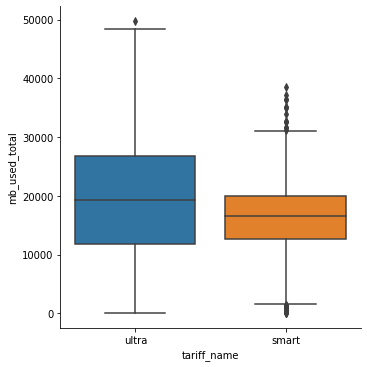

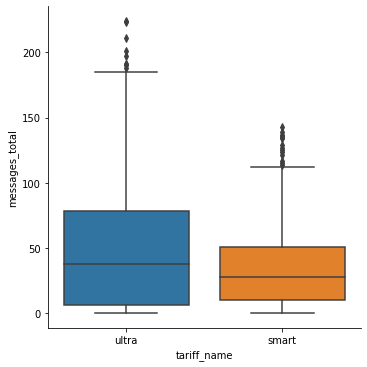

In [21]:
for column in ['minutes_total', 'mb_used_total', 'messages_total']: # строим диаграммы размаха    
    sns.catplot(x='tariff_name', y=column, kind="box", data=udpm, orient='v')

Согласно графикам, медианы по всем 3 признакам тарифа ultra смещены в большую сторону. Дисперсия всех трех величин также больше у тарифа ultra. А вот выбросов, наоборот, существенно больше у тарифа smart.

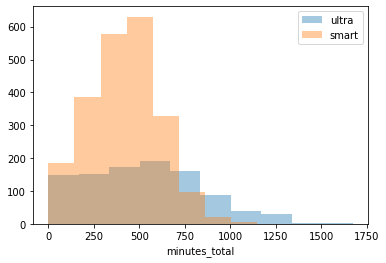

In [22]:
for tariff in ['ultra', 'smart']: # строим гистограммы
    sns.distplot(udpm.query('tariff_name == @tariff')['minutes_total'], kde=False, label=tariff, bins=10)
_ = plt.legend(['ultra', 'smart'])

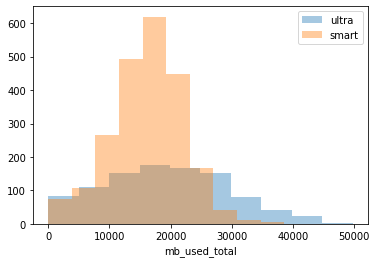

In [23]:
for tariff in ['ultra', 'smart']:
    sns.distplot(udpm.query('tariff_name == @tariff')['mb_used_total'], kde=False, bins=10)
_ = plt.legend(['ultra', 'smart'])

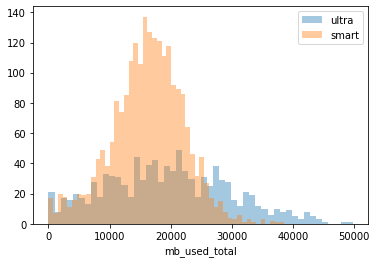

In [24]:
# check
for tariff in ['ultra', 'smart']:
    sns.distplot(udpm.query('tariff_name == @tariff')['mb_used_total'], kde=False, bins=50)
_ = plt.legend(['ultra', 'smart'])

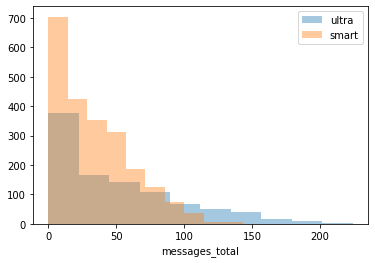

In [25]:
for tariff in ['ultra', 'smart']:
    sns.distplot(udpm.query('tariff_name == @tariff')['messages_total'], kde=False, label=tariff, bins=10)
_ = plt.legend(['ultra', 'smart'])

Гистограммы подтверждают предыдущий вывод о том, что дисперсия всех величин у тарифа ultra больше, чем у тарифа smart. Форма самих гистограмм достаточно сильно различается: мода у тарифа smart во всех трех случаях выражена гораздо сильнее, чем у тарифа ultra (выраженная мода у тарифа ultra есть только на гистограмме распрелеления сообщений). Разница в моде свидетельствует о наличии большей вариативности расходования лимитов у пользователей тарифа ultra. Вероятно, причина этого кроется в размерах самих лимитов: чем они больше, тем свободнее пользователи могут их расходовать, не опасаясь лишних переплат. Гистограммы распределения минут и сообщений скошены вправо, в то время как гистограмма распределения интернет-трафика ближе к нормальному распределению.

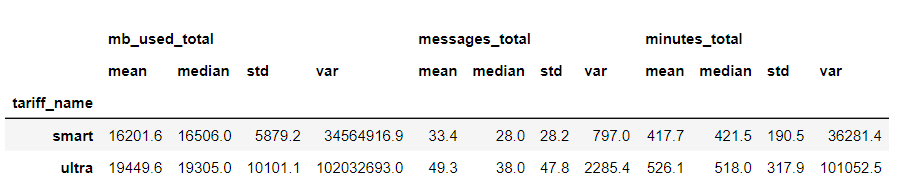

### Проверка гипотез

Перейдем к проверке гипотез. 
Первая гипотеза, которую необходимо проверить, имеет следующую формулировку: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются". Примем в качестве нулевой гипотезы H₀ обратное утверждение: "Средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт»", поскольку H₀ всегда формулируется так, чтобы использовать знак равенства. Другими словами, чтобы все данные лежали в районе изначально предполагаемого значения. Тогда, альтернативной гипотезой H₁ признаем изначальную: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются". Данная альтернативная гипотеза является двусторонней, потому что есть возможное отклонение и в большую, и в меньшую стороны. Критический уровень статистической значимости alpha установим равным 1%, поскольку объем выборки измеряется сотнями. 

In [26]:
ultra = udpm.query('tariff_name == "ultra"')['revenue'] # проверяем нулевую и альтернативную гипотезы 
smart = udpm.query('tariff_name == "smart"')['revenue'] # с помощью t-теста

alpha = .01

results = st.ttest_ind(ultra, smart, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


In [27]:
udpm.pivot_table(index='tariff_name', values='revenue', aggfunc='mean') # средняя выручка по тарифам

,revenue
tariff_name,
smart,1289.641704
ultra,2070.030426


In [28]:
udpm.pivot_table(index='tariff_name', values='revenue', aggfunc='sum') # общая выручка по тарифам

,revenue
tariff_name,
smart,2875901.0
ultra,2041050.0


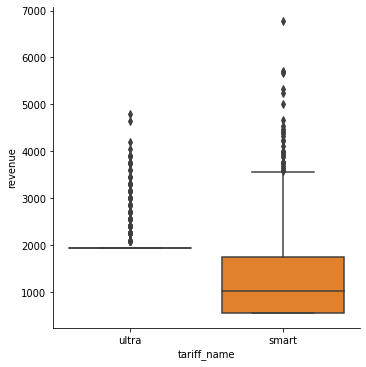

In [29]:
_ = sns.catplot(x="tariff_name", y='revenue', kind="box", data=udpm, orient='v')

Средняя выручка по тарифам различается примерно в 1,6 раза (smart - 1289 руб., ultra - 2070 руб.). Примечательно, что средняя выручка по тарифу smart не совпадает с установленной ежемесячной платой в 550 руб. Это свидетельствует о том, что пользователям данного тарифа часто приходится доплачивать из-за исчерпывания лимитов.

Нулевая гипотеза о равенстве выручки пользователей тарифов smart и ultra оказалась отвергнута. Следовательно, выручка действительно различается. P-значение 1.92 свидетельствует о том, что вероятность ошибки в данном случае минимальна.

Перейдем ко второй гипотезе. Ее формулировка: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов". По аналогии с первой гипотезой, примем за H₀ обратное утверждение: "Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов". Тогда H₁: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов". Критический уровень статистической значимости alpha как и ранее установим равным 1%.    

In [30]:
moscow = udpm.query('city == "Москва"')['revenue']  # проверяем нулевую и альтернативную гипотезы 
regions = udpm.query('city != "Москва"')['revenue'] # с помощью t-теста

alpha = .01

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


In [31]:
def get_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
udpm['region'] = udpm['city'].apply(get_region)
udpm.pivot_table(index='region', values='revenue', aggfunc='mean')

,revenue
region,
Другой регион,1524.725144
Москва,1546.713584


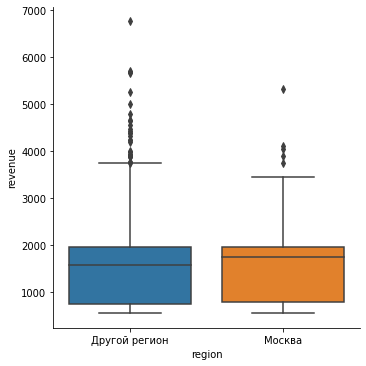

In [32]:
_ = sns.catplot(x="region", y='revenue', kind="box", data=udpm, orient='v')

In [33]:
users['city'].value_counts() # количество пользователей по городам

Москва             99
Санкт-Петербург    39
Новосибирск        16
Казань             14
Омск               14
                   ..
Архангельск         1
Подольск            1
Нижневартовск       1
Иваново             1
Химки               1
Name: city, Length: 76, dtype: int64

В результате t-теста нулевая гипотеза не была отвергнута. Действительно, согласно расчетам, средняя выручка с пользователя в Москве практически равна средней выручке с пользователей в других регионах (Москва - 1546 руб., другие регионы - 1524 руб.), при том, что последних количественно гораздо больше (99 в Москве, 401 в остальных регионах вместе взятых). По всей видимости, региональный фактор не оказывает достаточно существенного влияния на выручку пользователей, хотя и непосредственно определяет их количество (лидеры по количеству пользователей - Москва, Санкт-Петербург). P-значение 0.52 означает, что вероятность получения наблюдаемых результатов (в случае, если не была отвергнута нулевая гипотеза) составляет около 52%. 

In [34]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


### Общий вывод

В ходе проведенного исследования были проанализированы данные о клиентах компании «Мегалайн», федерального оператора сотовой связи. Задача — проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

В полученных входных данных наблюдалось несоответствие типов данных содержанию столбцов. Проблема были устранена в процессе исследования, а данные — приведены в пригодное для проведения анализа состояние.

В результате исследовательского анализа данных было установлено следующее:

- Суммарная выручка за 2018 год: тариф smart - 2875901 руб., ultra - 2041050. Выручка с тарифа smart больше на 834851 руб. (40,9%).   


- Пользователей тарифа smart больше на 202 человека (smart - 351 чел., ultra - 149 чел.). 


- В среднем, пользователи тарифа ultra расходуют больше минут, сообщений и мегабайт, чем пользователи тарифа smart, однако, как правило, не превышают лимитов. Примечательно, что пользователи тарифа ultra в среднем расходуют Мб трафика существенно меньше лимита (19449 из 30720 Мб), в то время как пользователям smart лимита часто не хватает (в среднем, расход 16201 Мб при лимите 15360).


- Мода признаков тарифа smart во всех трех случаях выражена гораздо сильнее, чем у тарифа ultra. Разница в моде свидетельствует о наличии большей вариативности расходования лимитов у пользователей тарифа ultra. Вероятно, причина этого кроется в размерах самих лимитов: чем они больше, тем свободнее пользователи могут их расходовать, не опасаясь лишних переплат.


- Средняя выручка с пользователя по тарифам различается примерно в 1,6 раза (smart - 1289 руб., ultra - 2070 руб.). Средняя выручка по тарифу smart не совпадает с установленной ежемесячной платой в 550 руб. Это свидетельствует о том, что пользователям данного тарифа часто приходится доплачивать из-за исчерпывания лимитов. Гипотеза о равенстве выручки пользователей тарифов smart и ultra оказалась отвергнута.


- Средняя выручка с пользователя в Москве практически равна средней выручке с пользователей в других регионах (регионы - 1524 руб., Москва - 1546 руб.). Разница статистически незначима (p-значение: 0,52). По всей видимости, региональный фактор не оказывает достаточно существенного влияния на выручку пользователей, хотя и непосредственно определяет их количество (лидеры по количеству пользователей - Москва, Санкт-Петербург).


- В целом, можно сделать предварительный вывод о том, что тариф ultra является для компании «Мегалайн» значительно более выгодным, поскольку в среднем приносит на 60,5% больше денег с пользователя, чем тариф smart. 



Таким образом, в ходе проведенного исследования поставленная задача была выполнена.